In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params, models, feats
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)
importlib.reload(feats)

<module 'libs.feats' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/feats.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os
import json

import time
import datetime as dt
from tqdm.auto import tqdm
from IPython.display import clear_output, display

In [3]:
df_sign = pd.read_csv(params.sign_csv, index_col=0, parse_dates=True) 

# Build main features day by day, showing a progress bar
frames = []
print("Generating main features…")
for day, day_df in tqdm(
    df_sign.groupby(df_sign.index.normalize()),
    desc="Days", unit="day"
):
    # day_df has only that session’s bars
    feats_main = feats.features_creation(df=day_df) # base_window for indicators calculation set by defauls as the smooth_sign_win
    frames.append(feats_main)

# Concatenate per-day feature frames back into one DataFrame
df_feat_main = pd.concat(frames).sort_index()

print('generating engineered features...')
df_feat_eng = feats.features_engineering(
                                        df = df_feat_main,
                                        low_rsi = 30,
                                        high_rsi = 70,
                                        adx_thresh = 20
                                        )

df_feat_eng

Generating main features…


Days:   0%|          | 0/5400 [00:00<?, ?day/s]

generating engineered features...


,ema_7,sma_7,sma_15,sma_30,macd_line,macd_signal,macd_diff,atr_15,atr_30,atr_15_sma_15,atr_30_sma_15,bb_lband_15,bb_hband_15,bb_width_15,rsi_15,stoch_k_15,stoch_d_3,plus_di_15,minus_di_15,adx_15,obv,obv_sma_15,vwap_dev_15,volume_spike_15,r_1,r_15,r_30,vol_15,hour,day_of_week,month,open,high,low,close,volume,bid,ask,signal,eng_ma,eng_macd,eng_bb,eng_rsi,eng_adx,eng_obv,eng_atr_div
2004-01-02 13:09:00,0.764265,0.764271,0.764279,0.764282,-0.000010,-0.000006,-0.000003,0.000003,0.000002,4.269180e-07,2.182953e-07,0.764250,0.764308,0.000077,0.000000,0.000000,0.000000,0.000000,100.000000,18.696296,6791837.50,6.777138e+06,-0.000053,1.567313,-0.000022,-0.000066,-0.000066,0.000009,13,4,1,0.764235,0.764235,0.764235,0.764235,48081.25,0.763664,0.764807,0.021536,-0.000,-0.000,0.000,30.0,0.000,1.470000e+04,NaN
2004-01-02 13:10:00,0.764253,0.764262,0.764275,0.764280,-0.000014,-0.000010,-0.000004,0.000004,0.000002,6.960758e-07,3.598283e-07,0.764233,0.764316,0.000109,0.000000,0.000000,0.000000,0.000000,100.000000,24.116543,6737062.50,6.785742e+06,-0.000066,1.687332,-0.000022,-0.000088,-0.000088,0.000010,13,4,1,0.764219,0.764219,0.764219,0.764219,54775.00,0.763647,0.764790,0.023284,-0.000,-0.000,0.000,30.0,-0.000,-4.867917e+04,NaN
2004-01-02 13:11:00,0.764240,0.764250,0.764269,0.764277,-0.000019,-0.000015,-0.000004,0.000005,0.000003,1.021695e-06,5.338459e-07,0.764214,0.764324,0.000143,0.000000,0.000000,0.000000,0.000000,100.000000,29.175440,6675593.75,6.788381e+06,-0.000076,1.771753,-0.000022,-0.000110,-0.000110,0.000011,13,4,1,0.764202,0.764202,0.764202,0.764202,61468.75,0.763631,0.764773,0.025175,-0.000,-0.000,0.000,30.0,-0.000,-1.127875e+05,NaN
2004-01-02 13:12:00,0.764227,0.764235,0.764262,0.764274,-0.000023,-0.000019,-0.000004,0.000006,0.000003,1.400010e-06,7.392654e-07,0.764194,0.764330,0.000178,0.000000,0.000000,0.000000,0.000000,100.000000,33.897078,6607431.25,6.784610e+06,-0.000085,1.823929,-0.000022,-0.000131,-0.000131,0.000011,13,4,1,0.764185,0.764185,0.764185,0.764185,68162.50,0.763614,0.764757,0.027222,-0.000,-0.000,0.000,30.0,-0.000,-1.771788e+05,NaN
2004-01-02 13:13:00,0.764212,0.764219,0.764254,0.764270,-0.000028,-0.000023,-0.000004,0.000006,0.000004,1.827510e-06,9.750399e-07,0.764173,0.764335,0.000212,0.000000,0.000000,0.000000,0.000000,100.000000,38.303939,6532575.00,6.773982e+06,-0.000091,1.848531,-0.000022,-0.000153,-0.000153,0.000011,13,4,1,0.764169,0.764169,0.764169,0.764169,74856.25,0.763597,0.764740,0.029436,-0.000,-0.000,0.000,30.0,-0.000,-2.414067e+05,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.566860,196.546529,196.366060,196.181343,0.149361,0.129311,0.020050,0.247178,0.219371,1.898364e-01,1.891945e-01,195.940174,196.791946,0.004338,66.709478,73.660714,62.548621,35.894912,7.957518,28.287412,4282659.00,3.226657e+06,0.001548,1.703441,0.000635,0.003639,0.004048,0.000804,20,2,6,196.680000,196.860000,196.630000,196.815000,385695.00,196.667400,196.962600,0.684908,0.386,0.020,0.023,0.0,8.287,1.056002e+06,2.9
2025-06-18 20:57:00,196.593895,196.556529,196.406393,196.210020,0.144209,0.136760,0.007449,0.256032,0.224725,1.960447e-01,1.923200e-01,195.985739,196.827047,0.004284,61.512097,58.962264,65.040993,34.426331,7.170155,30.769930,3822029.00,3.291745e+06,0.000637,1.841981,-0.000712,0.003081,0.004384,0.000836,20,2,6,196.810000,196.940000,196.560000,196.675000,460630.00,196.527500,196.822500,0.612206,0.384,0.007,0.000,0.0,10.770,5.302840e+05,3.0
2025-06-18 20:58:00,196.612921,196.615714,196.436393,196.244687,0.135696,0.136228,-0.000532,0.246297,0.220901,2.015723e-01,1.952080e-01,196.009058,196.863728,0.004351,61.329258,58.091247,63.571408,33.401309,6.956668,33.086948,3296784.00,3.315636e+06,0.000485,1.883214,-0.000025,0.002291,0.005302,0.000823,20,2,6,196.675000,196.740000,196.630000,196.670000,525245.00,196.522500,196.817500,0.610468,0.368,-0.001,0.000,0.0,13.0

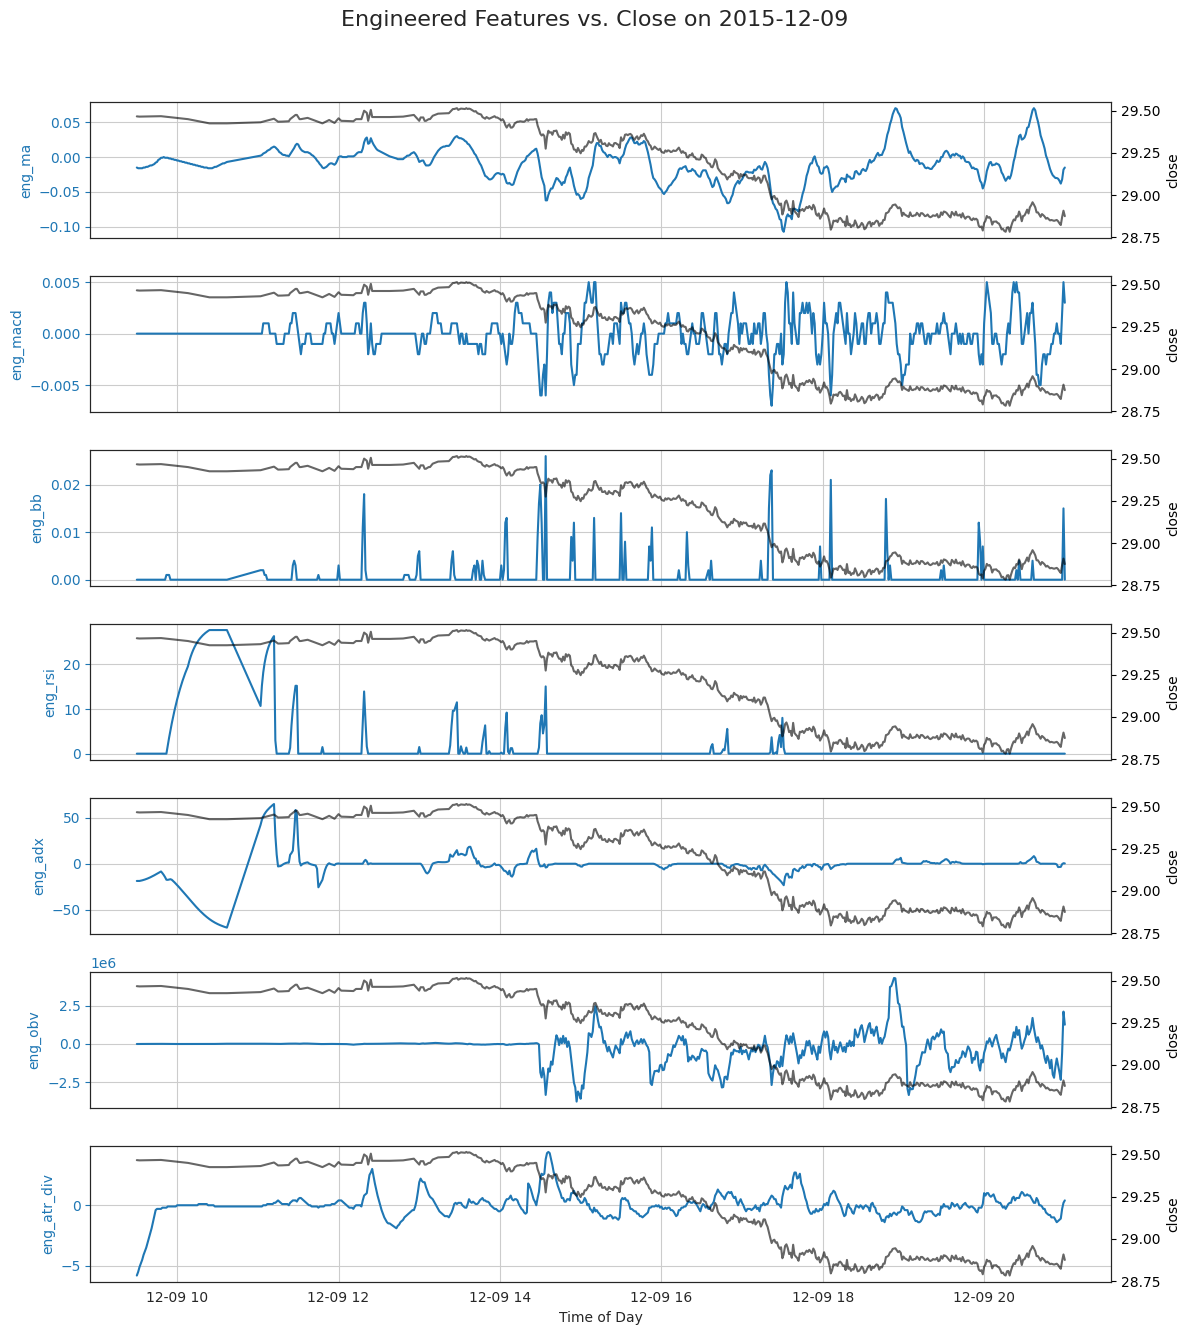

In [4]:
# 1) Identify engineered‐feature columns and the raw close price column
eng_features = [c for c in df_feat_eng.columns if c.startswith("eng_")]
close_col    = "close"

# 2) Pick a random trading day and convert to pandas Timestamp
all_days   = df_feat_eng.index.normalize().unique()
random_day = np.random.choice(all_days)
day_ts     = pd.to_datetime(random_day)

# 3) Subset the DataFrame to that single day
mask         = df_feat_eng.index.normalize() == random_day
df_day_feats = df_feat_eng.loc[mask, eng_features]
df_day_close = df_feat_eng.loc[mask, close_col]

# 4) Create one subplot per engineered feature
fig, axes = plt.subplots(
    nrows   = len(eng_features),
    ncols   = 1,
    figsize = (12, 2 * len(eng_features)),
    sharex  = True
)
fig.suptitle(f"Engineered Features vs. Close on {day_ts.date()}", fontsize=16)

# 5) Plot each feature on its own left‐y axis, and close price on a right‐y axis
for ax, feat in zip(axes, eng_features):
    # left axis: engineered feature
    ax.plot(df_day_feats.index, df_day_feats[feat],
            color="C0", label=feat)
    ax.set_ylabel(feat, color="C0")
    ax.tick_params(axis="y", colors="C0")
    ax.grid(True)

    # right axis: raw close price
    ax2 = ax.twinx()
    ax2.plot(df_day_close.index, df_day_close,
             color="k", alpha=0.6, label="close")
    ax2.set_ylabel("close", color="k")
    ax2.tick_params(axis="y", colors="k")

# 6) Final formatting
axes[-1].set_xlabel("Time of Day")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


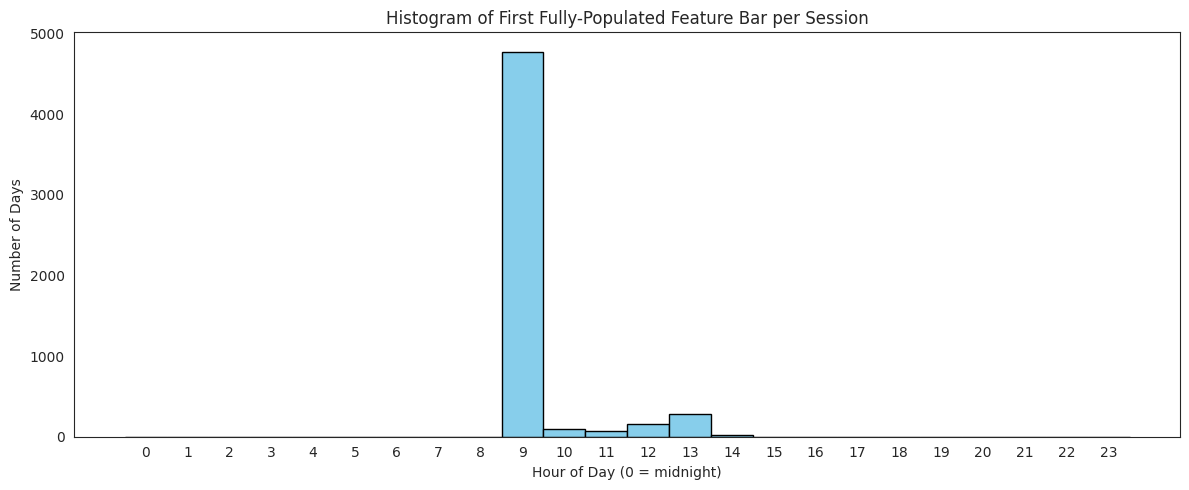

In [5]:
# -----------------------------------------------------------------------------
# What this plot shows:
#   We measure, for each trading day, the first 1-minute bar when *every* feature has a non-null value.  
#   Plotting the histogram of those hours tells how long the indicators take to “warm up” each morning before the model can run.
# -----------------------------------------------------------------------------

# 1) Prepare a DataFrame without bid/ask (and any non-feature cols)
df_feat_unsc = df_feat_eng.drop(columns=["bid", "ask"], errors="ignore")

# 2) Identify all feature columns (those starting with "feat_")
feat_cols = [c for c in df_feat_unsc.columns if c != 'signal']

# 3) For each calendar day, find the first timestamp where *all* feat_ cols are non-null
first_valid = (
    df_feat_unsc
      .groupby(df_feat_unsc.index.normalize())
      .apply(lambda grp: grp.dropna(subset=feat_cols).index.min())
)

# 4) Extract the hour (0–23) of that first fully-populated bar
first_valid_hours = first_valid.dt.hour

# 5) Plot the histogram
plt.figure(figsize=(12, 5))
plt.hist(
    first_valid_hours,
    bins=range(0, 25),       # 24 one-hour bins
    align='left',
    color='skyblue',
    edgecolor='black'
)
plt.xticks(range(0, 24))
plt.xlabel('Hour of Day (0 = midnight)')
plt.ylabel('Number of Days')
plt.title('Histogram of First Fully-Populated Feature Bar per Session')
plt.tight_layout()
plt.show()


In [ ]:
# importlib.reload(feats) ############################

# feed the trimmed DataFrame into the existing call
df_feat_all = feats.scale_with_splits(
    df           = df_feat_eng,
    train_prop   = params.train_prop,
    val_prop     = params.val_prop
)

df_feat_all

Train days:   0%|          | 0/3834 [00:00<?, ?day/s]

Val days:   0%|          | 0/785 [00:00<?, ?day/s]

Test days:   0%|          | 0/783 [00:00<?, ?day/s]

PCA compress:   0%|          | 0/3 [00:00<?, ?feat/s]

In [ ]:
df_feat_scal = df_feat_all.drop(['bid','ask'], axis=1)

plots.plot_dual_histograms(
    df_before = df_feat_unsc,
    df_after  = df_feat_scal,
)

In [ ]:
print("saving df …")
df_feat_all.to_csv(params.feat_all_csv) # saving also bid and ask